Assignment Overview
-----------------------------------

### 6.1 Assignment: Build a Baseline Model

### Objective:
You will enhance the classification model previously built in the session to predict loan defaults using the Lending Club dataset. Please use the 100k row sample as starting point for your model.  

#### Part 1 - Mandatory
Build a second model, `model_2`:
- selecting additional variables
- performing feature engineering (feel free to use features engineered previously)
- performing cross-validation 
- dealing with class imbalance 
- any additional techniques you would like to add to improve your model, at your discretion 

Compare it to `model` by using the evaluation metrics covered in this session.

#### Part 2 - Optional
As a data scientist working for the business, your objective is to **minimize the average cost of default** and **maximize the average income on loans**. Optimise `model_2` on this basis, leveraging a **custom loss function** (see 7.2 below) and considering the **following information on the cost of misclassifying** unseen observations:
##### Misclassification cost, and importance of False Positives and False Negatives:
-   **False Positives (FP)**: Predicting a loan as default when it is not. This can lead to lost opportunities for the lender since a potentially profitable loan is denied. Given the **FP_cost = 100**, the cost is relatively low, but it can accumulate over multiple instances.

-   **False Negatives (FN)**: Predicting a loan as non-default when it actually defaults. This is much more severe because it results in financial loss to the lender. Given the **FN_cost = 1000**, the cost here is much higher, reflecting the significant impact of a loan defaulting when it was predicted otherwise.


#### Part 3 - Optional
The business also wants you to do a PoC to see if they can predict `loan_amnt` based on the following features (feel free to use additional ones if you would like): `emp_length`,`home_ownership`, `annual_inc`.
Build a brand new regression model, `reg_model`, leveraging `LinearRegression` from `sklearn.linear_model` ( see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html))


### Tips:
-   **Feature Engineering**: Explore new features that might improve model performance. You may want or need to use some of the techniques covered in session 3.
-   **Cross-Validation**: Implement cross-validation to ensure your model does not overfit to the training data.
-   **Threshold Adjustment**: Consider adjusting the decision threshold to balance false positives and false negatives based on the associated costs.

### Deliverables:

-   A Jupyter Notebook containing:
    -   Detailed explanations of feature selection and engineering.
    -   Cross-validation implementation.
    -   Final model performance evaluation using custom loss metrics (FP_cost and FN_cost).
    -   Part 2 (optional): Custom loss function implementation and loss optimisation



### Set up

In [863]:
python_material_folder_name = "python-material"

#### Import libraries

In [865]:
#Import library
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = "/Users/hisay/Desktop/Courses/DSFinance/Data_Science_in_Finance_Resources/python-material"

# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3-100ksample.csv")
df.head()

#Read the dictionary file
df_dictionary = pd.read_excel(f"{path_python_material}/data/1-raw/lending-club-2007-2020Q3/LCDataDictionary.xlsx")

# Convert to Markdown format
from IPython.display import Markdown
markdown_table = df_dictionary.to_markdown(index=False)  
print("\n Here is the Dictionary for the list of the variables \n")
display(Markdown(markdown_table))  # Display as Markdown 


 Here is the Dictionary for the list of the variables 



| LoanStatNew                                | Description                                                                                                                                                                                                                               |
|:-------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| acc_now_delinq                             | The number of accounts on which the borrower is now delinquent.                                                                                                                                                                           |
| acc_open_past_24mths                       | Number of trades opened in past 24 months.                                                                                                                                                                                                |
| addr_state                                 | The state provided by the borrower in the loan application                                                                                                                                                                                |
| all_util                                   | Balance to credit limit on all trades                                                                                                                                                                                                     |
| annual_inc                                 | The self-reported annual income provided by the borrower during registration.                                                                                                                                                             |
| annual_inc_joint                           | The combined self-reported annual income provided by the co-borrowers during registration                                                                                                                                                 |
| application_type                           | Indicates whether the loan is an individual application or a joint application with two co-borrowers                                                                                                                                      |
| avg_cur_bal                                | Average current balance of all accounts                                                                                                                                                                                                   |
| bc_open_to_buy                             | Total open to buy on revolving bankcards.                                                                                                                                                                                                 |
| bc_util                                    | Ratio of total current balance to high credit/credit limit for all bankcard accounts.                                                                                                                                                     |
| chargeoff_within_12_mths                   | Number of charge-offs within 12 months                                                                                                                                                                                                    |
| collection_recovery_fee                    | post charge off collection fee                                                                                                                                                                                                            |
| collections_12_mths_ex_med                 | Number of collections in 12 months excluding medical collections                                                                                                                                                                          |
| delinq_2yrs                                | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years                                                                                                                              |
| delinq_amnt                                | The past-due amount owed for the accounts on which the borrower is now delinquent.                                                                                                                                                        |
| desc                                       | Loan description provided by the borrower                                                                                                                                                                                                 |
| dti                                        | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.                                  |
| dti_joint                                  | A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income                        |
| earliest_cr_line                           | The month the borrower's earliest reported credit line was opened                                                                                                                                                                         |
| emp_length                                 | Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.                                                                                                         |
| emp_title                                  | The job title supplied by the Borrower when applying for the loan.*                                                                                                                                                                       |
| fico_range_high                            | The upper boundary range the borrower’s FICO at loan origination belongs to.                                                                                                                                                              |
| fico_range_low                             | The lower boundary range the borrower’s FICO at loan origination belongs to.                                                                                                                                                              |
| funded_amnt                                | The total amount committed to that loan at that point in time.                                                                                                                                                                            |
| funded_amnt_inv                            | The total amount committed by investors for that loan at that point in time.                                                                                                                                                              |
| grade                                      | LC assigned loan grade                                                                                                                                                                                                                    |
| home_ownership                             | The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER                                                                                     |
| id                                         | A unique LC assigned ID for the loan listing.                                                                                                                                                                                             |
| il_util                                    | Ratio of total current balance to high credit/credit limit on all install acct                                                                                                                                                            |
| initial_list_status                        | The initial listing status of the loan. Possible values are – W, F                                                                                                                                                                        |
| inq_fi                                     | Number of personal finance inquiries                                                                                                                                                                                                      |
| inq_last_12m                               | Number of credit inquiries in past 12 months                                                                                                                                                                                              |
| inq_last_6mths                             | The number of inquiries in past 6 months (excluding auto and mortgage inquiries)                                                                                                                                                          |
| installment                                | The monthly payment owed by the borrower if the loan originates.                                                                                                                                                                          |
| int_rate                                   | Interest Rate on the loan                                                                                                                                                                                                                 |
| issue_d                                    | The month which the loan was funded                                                                                                                                                                                                       |
| last_credit_pull_d                         | The most recent month LC pulled credit for this loan                                                                                                                                                                                      |
| last_fico_range_high                       | The upper boundary range the borrower’s last FICO pulled belongs to.                                                                                                                                                                      |
| last_fico_range_low                        | The lower boundary range the borrower’s last FICO pulled belongs to.                                                                                                                                                                      |
| last_pymnt_amnt                            | Last total payment amount received                                                                                                                                                                                                        |
| last_pymnt_d                               | Last month payment was received                                                                                                                                                                                                           |
| loan_amnt                                  | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.                                                              |
| loan_status                                | Current status of the loan                                                                                                                                                                                                                |
| max_bal_bc                                 | Maximum current balance owed on all revolving accounts                                                                                                                                                                                    |
| member_id                                  | A unique LC assigned Id for the borrower member.                                                                                                                                                                                          |
| mo_sin_old_il_acct                         | Months since oldest bank installment account opened                                                                                                                                                                                       |
| mo_sin_old_rev_tl_op                       | Months since oldest revolving account opened                                                                                                                                                                                              |
| mo_sin_rcnt_rev_tl_op                      | Months since most recent revolving account opened                                                                                                                                                                                         |
| mo_sin_rcnt_tl                             | Months since most recent account opened                                                                                                                                                                                                   |
| mort_acc                                   | Number of mortgage accounts.                                                                                                                                                                                                              |
| mths_since_last_delinq                     | The number of months since the borrower's last delinquency.                                                                                                                                                                               |
| mths_since_last_major_derog                | Months since most recent 90-day or worse rating                                                                                                                                                                                           |
| mths_since_last_record                     | The number of months since the last public record.                                                                                                                                                                                        |
| mths_since_rcnt_il                         | Months since most recent installment accounts opened                                                                                                                                                                                      |
| mths_since_recent_bc                       | Months since most recent bankcard account opened.                                                                                                                                                                                         |
| mths_since_recent_bc_dlq                   | Months since most recent bankcard delinquency                                                                                                                                                                                             |
| mths_since_recent_inq                      | Months since most recent inquiry.                                                                                                                                                                                                         |
| mths_since_recent_revol_delinq             | Months since most recent revolving delinquency.                                                                                                                                                                                           |
| next_pymnt_d                               | Next scheduled payment date                                                                                                                                                                                                               |
| num_accts_ever_120_pd                      | Number of accounts ever 120 or more days past due                                                                                                                                                                                         |
| num_actv_bc_tl                             | Number of currently active bankcard accounts                                                                                                                                                                                              |
| num_actv_rev_tl                            | Number of currently active revolving trades                                                                                                                                                                                               |
| num_bc_sats                                | Number of satisfactory bankcard accounts                                                                                                                                                                                                  |
| num_bc_tl                                  | Number of bankcard accounts                                                                                                                                                                                                               |
| num_il_tl                                  | Number of installment accounts                                                                                                                                                                                                            |
| num_op_rev_tl                              | Number of open revolving accounts                                                                                                                                                                                                         |
| num_rev_accts                              | Number of revolving accounts                                                                                                                                                                                                              |
| num_rev_tl_bal_gt_0                        | Number of revolving trades with balance >0                                                                                                                                                                                                |
| num_sats                                   | Number of satisfactory accounts                                                                                                                                                                                                           |
| num_tl_120dpd_2m                           | Number of accounts currently 120 days past due (updated in past 2 months)                                                                                                                                                                 |
| num_tl_30dpd                               | Number of accounts currently 30 days past due (updated in past 2 months)                                                                                                                                                                  |
| num_tl_90g_dpd_24m                         | Number of accounts 90 or more days past due in last 24 months                                                                                                                                                                             |
| num_tl_op_past_12m                         | Number of accounts opened in past 12 months                                                                                                                                                                                               |
| open_acc                                   | The number of open credit lines in the borrower's credit file.                                                                                                                                                                            |
| open_acc_6m                                | Number of open trades in last 6 months                                                                                                                                                                                                    |
| open_il_12m                                | Number of installment accounts opened in past 12 months                                                                                                                                                                                   |
| open_il_24m                                | Number of installment accounts opened in past 24 months                                                                                                                                                                                   |
| open_act_il                                | Number of currently active installment trades                                                                                                                                                                                             |
| open_rv_12m                                | Number of revolving trades opened in past 12 months                                                                                                                                                                                       |
| open_rv_24m                                | Number of revolving trades opened in past 24 months                                                                                                                                                                                       |
| out_prncp                                  | Remaining outstanding principal for total amount funded                                                                                                                                                                                   |
| out_prncp_inv                              | Remaining outstanding principal for portion of total amount funded by investors                                                                                                                                                           |
| pct_tl_nvr_dlq                             | Percent of trades never delinquent                                                                                                                                                                                                        |
| percent_bc_gt_75                           | Percentage of all bankcard accounts > 75% of limit.                                                                                                                                                                                       |
| policy_code                                | publicly available policy_code=1                                                                                                                                                                                                          |
|                                            | new products not publicly available policy_code=2                                                                                                                                                                                         |
| pub_rec                                    | Number of derogatory public records                                                                                                                                                                                                       |
| pub_rec_bankruptcies                       | Number of public record bankruptcies                                                                                                                                                                                                      |
| purpose                                    | A category provided by the borrower for the loan request.                                                                                                                                                                                 |
| pymnt_plan                                 | Indicates if a payment plan has been put in place for the loan                                                                                                                                                                            |
| recoveries                                 | post charge off gross recovery                                                                                                                                                                                                            |
| revol_bal                                  | Total credit revolving balance                                                                                                                                                                                                            |
| revol_util                                 | Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.                                                                                                                |
| sub_grade                                  | LC assigned loan subgrade                                                                                                                                                                                                                 |
| tax_liens                                  | Number of tax liens                                                                                                                                                                                                                       |
| term                                       | The number of payments on the loan. Values are in months and can be either 36 or 60.                                                                                                                                                      |
| title                                      | The loan title provided by the borrower                                                                                                                                                                                                   |
| tot_coll_amt                               | Total collection amounts ever owed                                                                                                                                                                                                        |
| tot_cur_bal                                | Total current balance of all accounts                                                                                                                                                                                                     |
| tot_hi_cred_lim                            | Total high credit/credit limit                                                                                                                                                                                                            |
| total_acc                                  | The total number of credit lines currently in the borrower's credit file                                                                                                                                                                  |
| total_bal_ex_mort                          | Total credit balance excluding mortgage                                                                                                                                                                                                   |
| total_bal_il                               | Total current balance of all installment accounts                                                                                                                                                                                         |
| total_bc_limit                             | Total bankcard high credit/credit limit                                                                                                                                                                                                   |
| total_cu_tl                                | Number of finance trades                                                                                                                                                                                                                  |
| total_il_high_credit_limit                 | Total installment high credit/credit limit                                                                                                                                                                                                |
| total_pymnt                                | Payments received to date for total amount funded                                                                                                                                                                                         |
| total_pymnt_inv                            | Payments received to date for portion of total amount funded by investors                                                                                                                                                                 |
| total_rec_int                              | Interest received to date                                                                                                                                                                                                                 |
| total_rec_late_fee                         | Late fees received to date                                                                                                                                                                                                                |
| total_rec_prncp                            | Principal received to date                                                                                                                                                                                                                |
| total_rev_hi_lim                           | Total revolving high credit/credit limit                                                                                                                                                                                                  |
| url                                        | URL for the LC page with listing data.                                                                                                                                                                                                    |
| verification_status                        | Indicates if income was verified by LC, not verified, or if the income source was verified                                                                                                                                                |
| verified_status_joint                      | Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified                                                                                                                        |
| zip_code                                   | The first 3 numbers of the zip code provided by the borrower in the loan application.                                                                                                                                                     |
| revol_bal_joint                            | Sum of revolving credit balance of the co-borrowers, net of duplicate balances                                                                                                                                                            |
| sec_app_fico_range_low                     | FICO range (high) for the secondary applicant                                                                                                                                                                                             |
| sec_app_fico_range_high                    | FICO range (low) for the secondary applicant                                                                                                                                                                                              |
| sec_app_earliest_cr_line                   | Earliest credit line at time of application for the secondary applicant                                                                                                                                                                   |
| sec_app_inq_last_6mths                     | Credit inquiries in the last 6 months at time of application for the secondary applicant                                                                                                                                                  |
| sec_app_mort_acc                           | Number of mortgage accounts at time of application for the secondary applicant                                                                                                                                                            |
| sec_app_open_acc                           | Number of open trades at time of application for the secondary applicant                                                                                                                                                                  |
| sec_app_revol_util                         | Ratio of total current balance to high credit/credit limit for all revolving accounts                                                                                                                                                     |
| sec_app_open_act_il                        | Number of currently active installment trades at time of application for the secondary applicant                                                                                                                                          |
| sec_app_num_rev_accts                      | Number of revolving accounts at time of application for the secondary applicant                                                                                                                                                           |
| sec_app_chargeoff_within_12_mths           | Number of charge-offs within last 12 months at time of application for the secondary applicant                                                                                                                                            |
| sec_app_collections_12_mths_ex_med         | Number of collections within last 12 months excluding medical collections at time of application for the secondary applicant                                                                                                              |
| sec_app_mths_since_last_major_derog        | Months since most recent 90-day or worse rating at time of application for the secondary applicant                                                                                                                                        |
| hardship_flag                              | Flags whether or not the borrower is on a hardship plan                                                                                                                                                                                   |
| hardship_type                              | Describes the hardship plan offering                                                                                                                                                                                                      |
| hardship_reason                            | Describes the reason the hardship plan was offered                                                                                                                                                                                        |
| hardship_status                            | Describes if the hardship plan is active, pending, canceled, completed, or broken                                                                                                                                                         |
| deferral_term                              | Amount of months that the borrower is expected to pay less than the contractual monthly payment amount due to a hardship plan                                                                                                             |
| hardship_amount                            | The interest payment that the borrower has committed to make each month while they are on a hardship plan                                                                                                                                 |
| hardship_start_date                        | The start date of the hardship plan period                                                                                                                                                                                                |
| hardship_end_date                          | The end date of the hardship plan period                                                                                                                                                                                                  |
| payment_plan_start_date                    | The day the first hardship plan payment is due. For example, if a borrower has a hardship plan period of 3 months, the start date is the start of the three-month period in which the borrower is allowed to make interest-only payments. |
| hardship_length                            | The number of months the borrower will make smaller payments than normally obligated due to a hardship plan                                                                                                                               |
| hardship_dpd                               | Account days past due as of the hardship plan start date                                                                                                                                                                                  |
| hardship_loan_status                       | Loan Status as of the hardship plan start date                                                                                                                                                                                            |
| orig_projected_additional_accrued_interest | The original projected additional interest amount that will accrue for the given hardship payment plan as of the Hardship Start Date. This field will be null if the borrower has broken their hardship payment plan.                     |
| hardship_payoff_balance_amount             | The payoff balance amount as of the hardship plan start date                                                                                                                                                                              |
| hardship_last_payment_amount               | The last payment amount as of the hardship plan start date                                                                                                                                                                                |
| disbursement_method                        | The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY                                                                                                                                               |
| debt_settlement_flag                       | Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.                                                                                                                                        |
| debt_settlement_flag_date                  | The most recent date that the Debt_Settlement_Flag has been set                                                                                                                                                                           |
| settlement_status                          | The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT                                                                                                                     |
| settlement_date                            | The date that the borrower agrees to the settlement plan                                                                                                                                                                                  |
| settlement_amount                          | The loan amount that the borrower has agreed to settle for                                                                                                                                                                                |
| settlement_percentage                      | The settlement amount as a percentage of the payoff balance amount on the loan                                                                                                                                                            |
| settlement_term                            | The number of months that the borrower will be on the settlement plan                                                                                                                                                                     |
| nan                                        | nan                                                                                                                                                                                                                                       |
| nan                                        | * Employer Title replaces Employer Name for all loans listed after 9/23/2013                                                                                                                                                              |

### Removal of unwanted columns



In [867]:
#Drop the Unnamed columns, just for the convenience
list_to_drop = ['Unnamed: 0.1', 'Unnamed: 0']#YOUR CODE HERE
df_new = df.drop(list_to_drop, axis= 1)
df_new.shape

(100000, 141)

In [868]:
#Display the updated datafranm
df_new.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B,B5,cashier,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B,B2,ABM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,39589826,5000.0,5000.0,5000.0,36 months,10.49%,162.49,B,B3,driver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,134798709,24000.0,24000.0,24000.0,60 months,11.05%,522.42,B,B4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,127097355,14000.0,14000.0,14000.0,60 months,13.59%,322.79,C,C2,Shipping Clerk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


### <span style = 'color: BLUE'> Exploratory data analysis

Here, I analyze the loan status to categorize the defaulter, non-defaulters and others.

*<span style = 'color: BLUE'>Useful definitions:*  
- *Defaulted Loan: A loan is considered in default when the borrower fails to make the required payments as agreed in the loan contract. Default typically occurs after missing several payments (usually 90 to 180 days, depending on the type of loan and lender policies).*
- *A loan is charged off when the lender writes off the loan as a bad debt on their financial statements, recognizing it as a loss. This typically happens after the loan has been in default for a significant period, often around 180 days.*

In [870]:
#The loan status
df_new.loan_status.value_counts()

loan_status
Fully Paid                                             51189
Current                                                35294
Charged Off                                            12384
Late (31-120 days)                                       535
In Grace Period                                          329
Late (16-30 days)                                         90
Does not meet the credit policy. Status:Fully Paid        69
Issued                                                    63
Does not meet the credit policy. Status:Charged Off       33
Default                                                   14
Name: count, dtype: int64

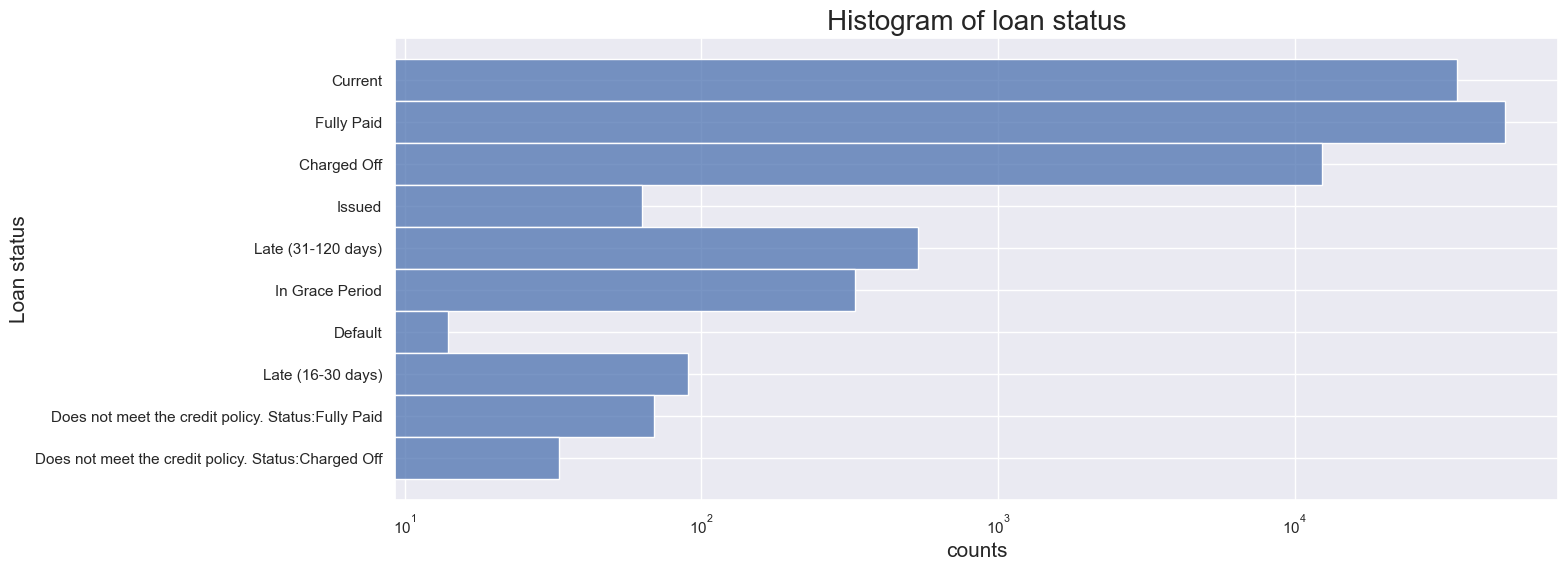

In [871]:
#Histogram plot
sns.set(rc={'figure.figsize':(15,6)})
sns.histplot(y = df['loan_status'], bins = 20)
plt.xscale('log')
plt.title("Histogram of loan status", fontsize=20)
plt.xlabel("counts", fontsize=15)
plt.ylabel("Loan status", fontsize=15);
plt.show()

Text(0, 0.5, 'Loan Status')

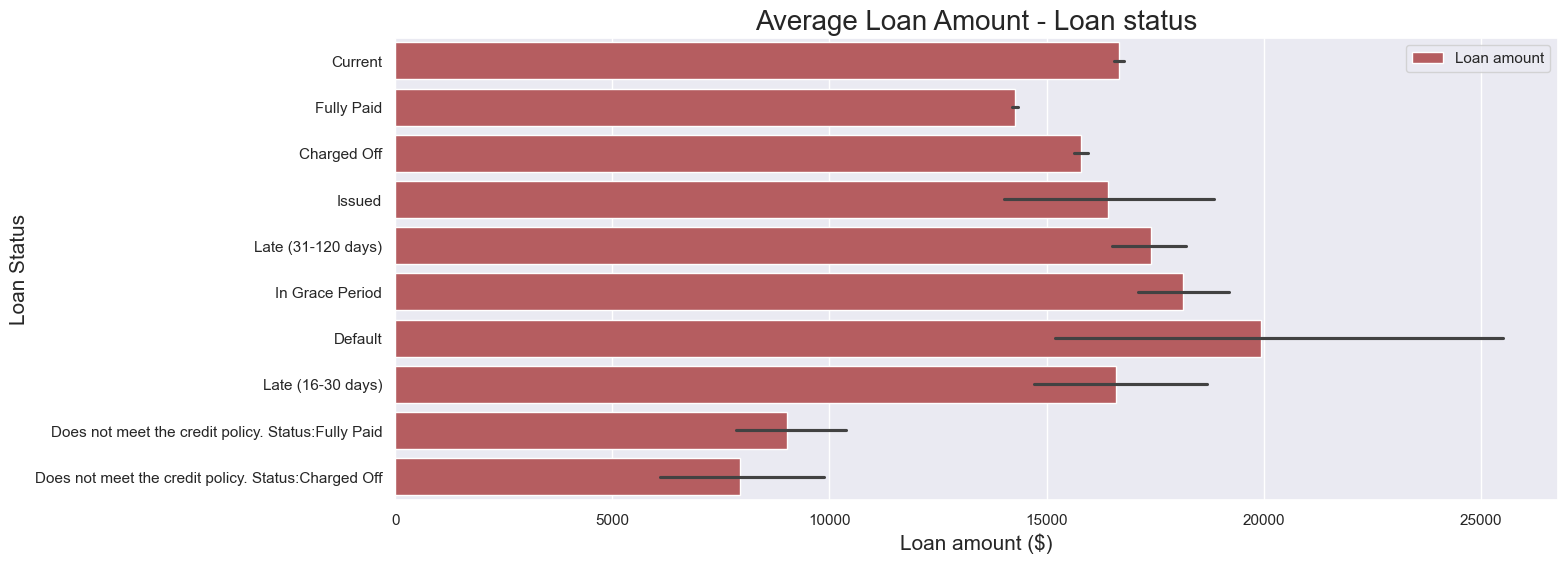

In [872]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'loan_status', data = df_new, label = "Loan amount", color = "r")
plt.title("Average Loan Amount - Loan status", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan Status", fontsize=15)

The plot clearly indicates that defaults are associated with higher loan amounts, typically exceeding 20,000 USD. Conversely, loans under 8,000 USD tend to fall into the "Does not meet credit policy" category, while those between 8,000 USD and 17,000 USD are spread across the remaining categories.

Text(0, 0.5, 'Loan Status')

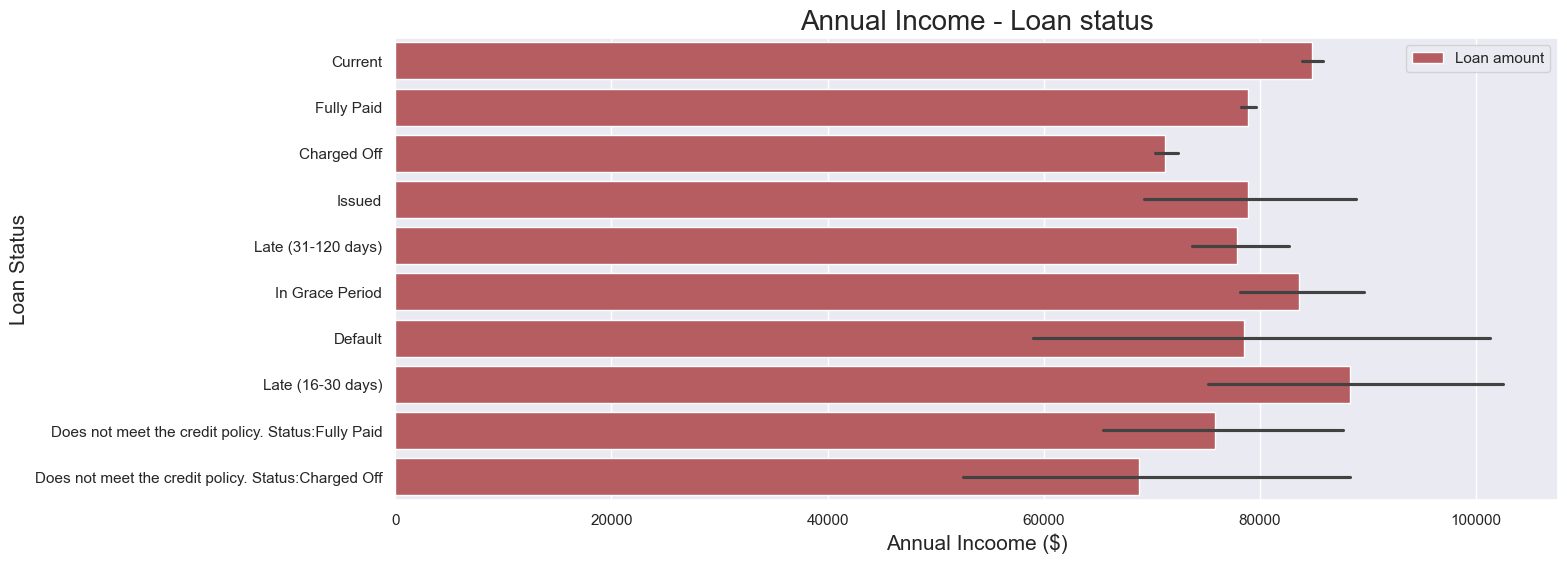

In [874]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'annual_inc', y = 'loan_status', data = df_new, label = "Loan amount", color = "r")
plt.title("Annual Income - Loan status", fontsize=20)
plt.xlabel("Annual Incoome ($)", fontsize=15)
plt.ylabel("Loan Status", fontsize=15)

We will break this plot later. 

Let's check whether type of application (individual or joint application) has any dependence on the loan amount.

In [876]:
#application type
num_unique = df_new["application_type"].unique()
print(num_unique)

['Individual' 'Joint App']


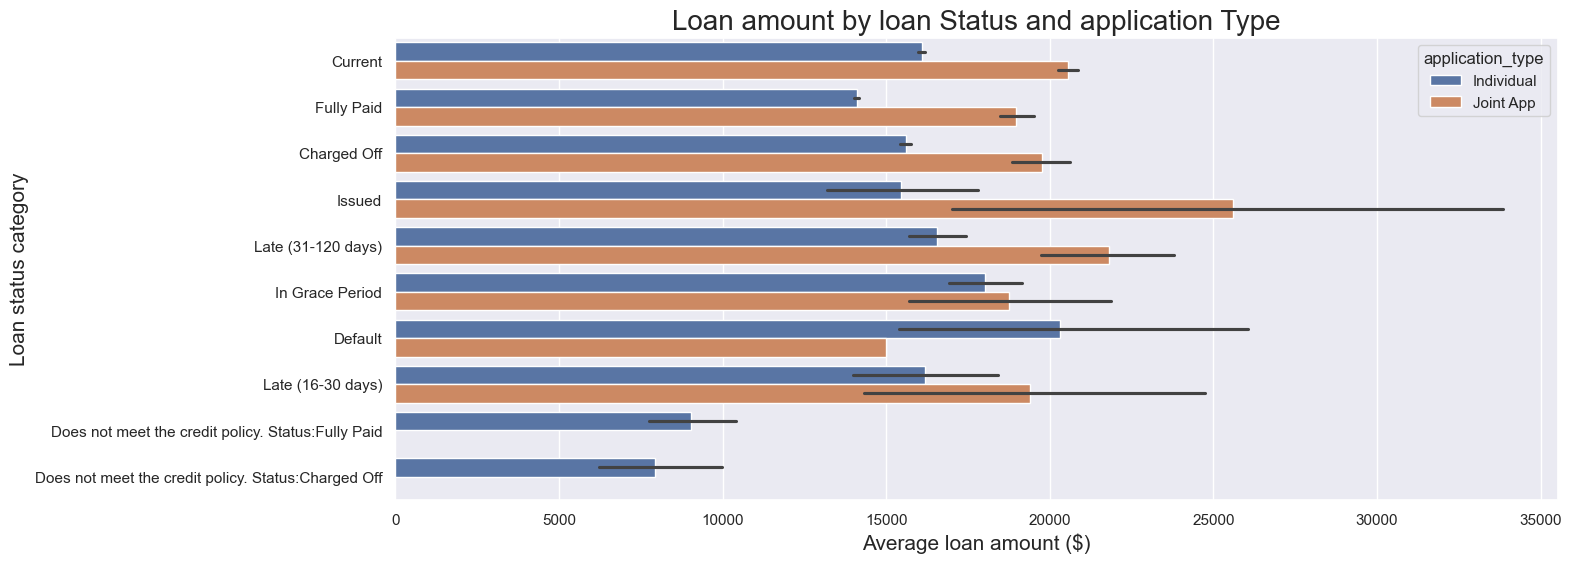

In [877]:
sns.set(rc={'figure.figsize': (15, 6)})
sns.barplot(y='loan_status', 
            x='loan_amnt', 
            hue='application_type', 
            data=df_new)
plt.title("Loan amount by loan Status and application Type", fontsize=20)
plt.ylabel("Loan status category", fontsize=15)
plt.xlabel("Average loan amount ($)", fontsize=15)
plt.show()

The higher loan was given to the joint application type applicant that's apparent. Lets see their density in the violin plot:

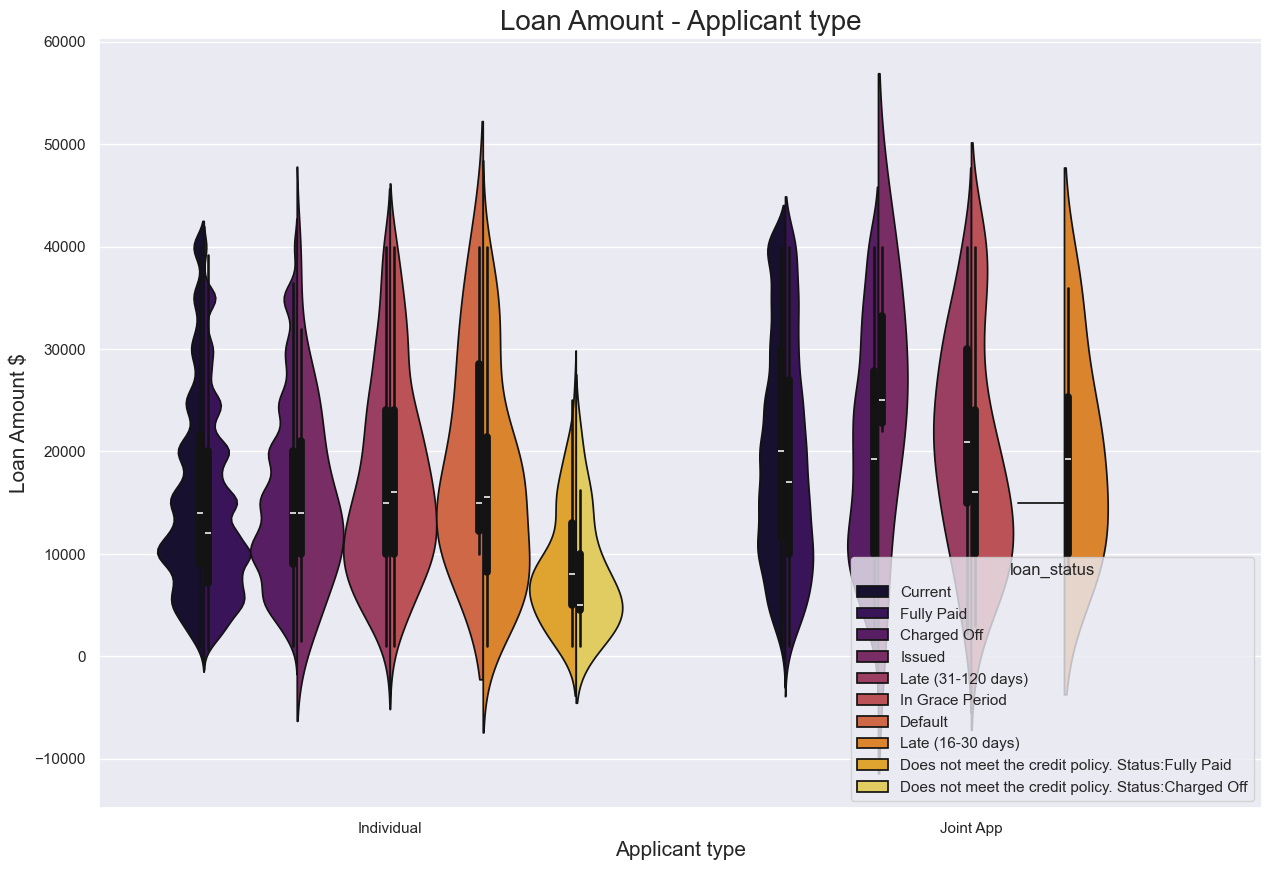

In [879]:
sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x="application_type",y="loan_amnt",data=df_new, 
               hue="loan_status", split=True,palette='inferno')
plt.title("Loan Amount - Applicant type", fontsize=20)
plt.xlabel("Applicant type", fontsize=15)
plt.ylabel("Loan Amount $", fontsize=15);

Some negative values of numeric data in the `loan amounts` were  detected, which requires some data cleaning at a later stage. `Defaults` are less with Joint type applicants.

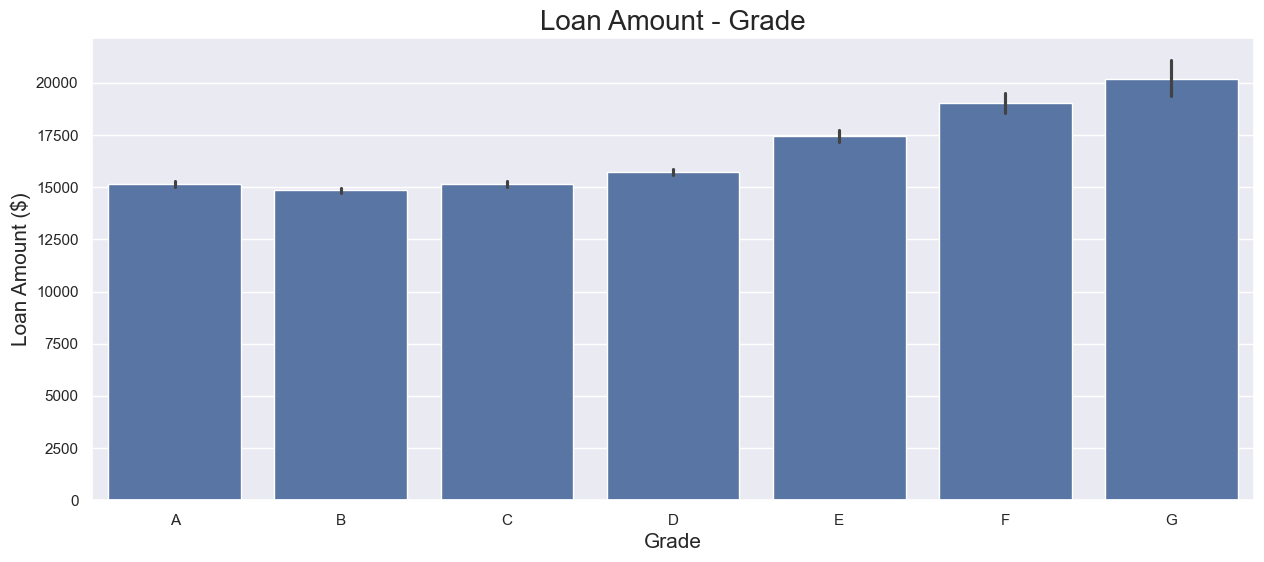

In [881]:
#Let's study now loan grades
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'loan_amnt', data = df_mapped_deduped, order="ABCDEFG")
plt.title("Loan Amount - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Loan Amount ($)", fontsize=15);

**Next, I combine the small-case and large-case labels in the data, as they are currently treated as separate labels.**

The column `grades` is assigned based on the average loan amount. For example `A` - 15000 \$ to `G` - 20000$, which shows that the highest grade equates to the greater loan amount. Now let's check how `interest rate` and `term` relates to the `grade`.

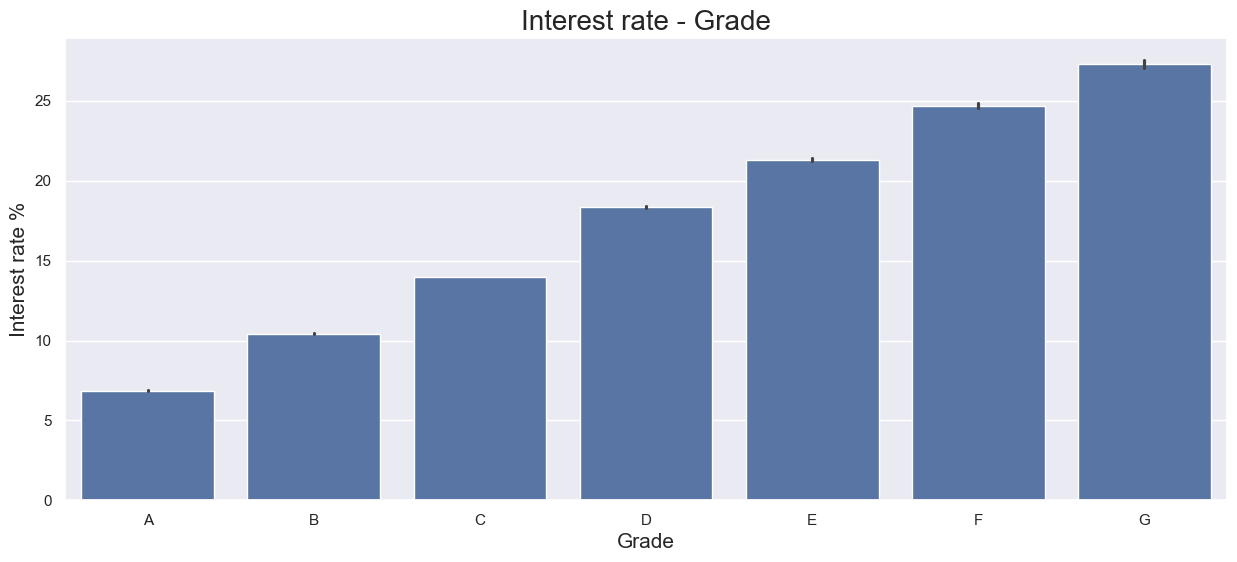

In [884]:
#I first chnaged the alpha numeric columns to a numeric columns
df_new['term_numeric'] = df_new['term'].str.extract(r'(\d+)').astype(int)
df_new['int_rate_numeric'] = df_new['int_rate'].str.extract(r'(\d+)').astype(int)

#sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'int_rate_numeric', data = df_new, order="ABCDEFG")
plt.title("Interest rate - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Interest rate %", fontsize=15);

It's apparent that the `Grade` is given based on the interest rate. Higher the interest rate, the higher the grade.

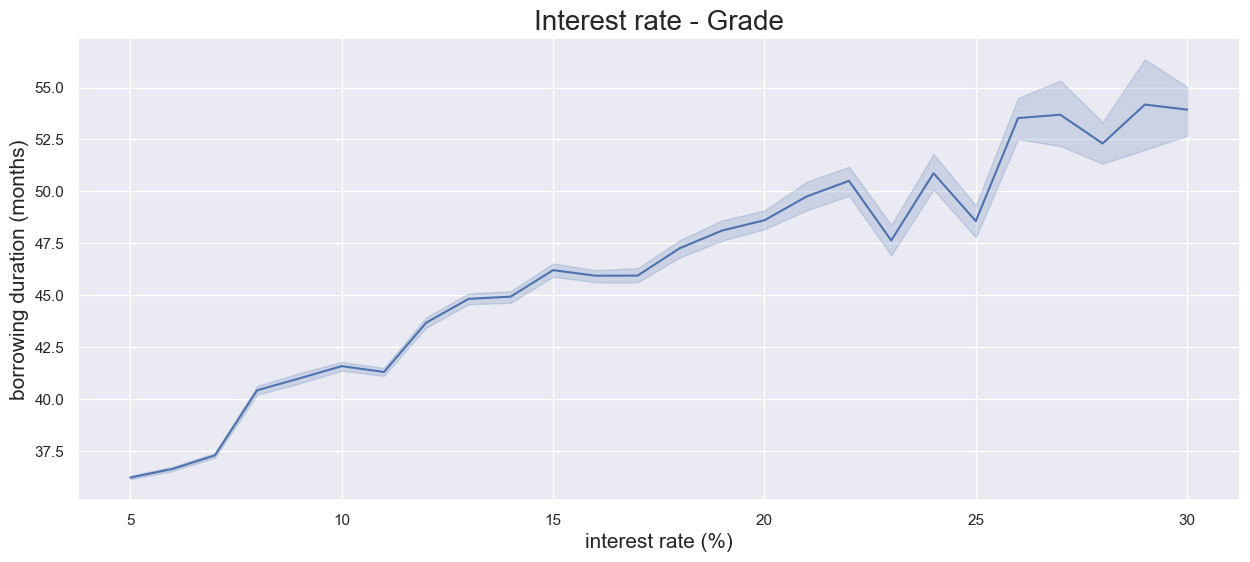

In [886]:
#sns.set(rc={'figure.figsize':(15,6)})
sns.lineplot(x = 'int_rate_numeric', y = 'term_numeric', data = df_new)
plt.title("Interest rate - Grade", fontsize=20)
plt.xlabel("interest rate (%)", fontsize=15)
plt.ylabel("borrowing duration (months)", fontsize=15);

This suggests that, on average, borrowers with longer loan durations are assigned higher interest rates.

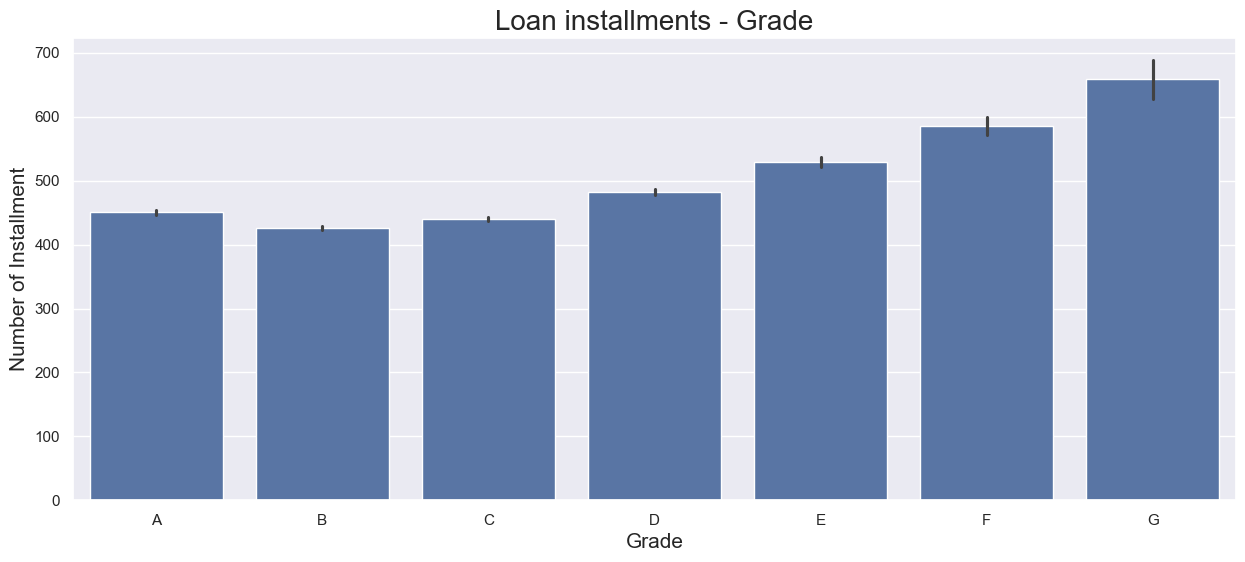

In [888]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'installment', data = df_new, order="ABCDEFG")
plt.title("Loan installments - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Number of Installment", fontsize=15);

Therefore, the number of installements are greater for higher loan which G grade.

### <span style = 'color: BLUE'> 2. Feature selection

Based on our exploratory data analysis, let's select a few important variables from the dataset for our analysis. 

<span style="color:BLUE"> **Most Important Variables for Loan Approval**
- `id`$\rightarrow$ ID number for borrower
- `annual_inc` $\rightarrow$  Self-reported annual income
- `loan_amnt` $\rightarrow$  Loan amount requested
- `loan_status` $\rightarrow$  Loan status (Fully Paid, Charged Off, Late, Default)
- `term` $\rightarrow$  Duration for loan repayment (36 or 60 months) (converted to numeric)
- `application_type` $\rightarrow$  Application type (Individual type or joint type)
- `int_rate`$\rightarrow$ interest rate (converted to numeric)
- `grades` $\rightarrow$ loan grades
- `installment` $\rightarrow$ The monthly payment amount.
- `(fico_range_high + fico_range_low)/2` $\rightarrow$  FICO credit score  - we will create them for our analysis

---
<span style='color:BLUE'>Some other variables (may be important):
- `pub_rec_bankruptcies` $\rightarrow$  Number of bankruptcies recorded
- `home_ownership` $\rightarrow$  MORTGAGE, RENT, OWN (Financial status)
- `out_prncp_inv` $\rightarrow$  Remaining outstanding principal
- `purpose` $\rightarrow$  Reason for loan (e.g., credit card debt consolidation, home improvement)
- `recoveries` $\rightarrow$ Amount recovered from charged-off loans.


These variables help **assess risk**, determine the **borrower’s ability to repay**, and predict **loan performance**.

In [891]:
#Make a clean data frame with the most important columns
df_clean = df_new[["id", "annual_inc","loan_amnt", "loan_status","term_numeric", "application_type",
                   "int_rate_numeric","grade", "installment", "fico_range_high", "fico_range_low", 
                   "pub_rec_bankruptcies", "home_ownership", "out_prncp_inv", "purpose", "recoveries"]]

df_clean.head()
                          

,id,annual_inc,loan_amnt,loan_status,term_numeric,application_type,int_rate_numeric,grade,installment,fico_range_high,fico_range_low,pub_rec_bankruptcies,home_ownership,out_prncp_inv,purpose,recoveries
0,167338079,48000.0,4000.0,Current,36,Individual,13,B,134.93,669.0,665.0,1.0,MORTGAGE,3816.34,home_improvement,0.0
1,71016917,57000.0,24000.0,Current,60,Individual,9,B,500.07,684.0,680.0,0.0,RENT,4333.29,credit_card,0.0
2,39589826,55000.0,5000.0,Fully Paid,36,Individual,10,B,162.49,669.0,665.0,0.0,MORTGAGE,0.00,credit_card,0.0
3,134798709,43500.0,24000.0,Current,60,Individual,11,B,522.42,754.0,750.0,0.0,MORTGAGE,16317.69,debt_consolidation,0.0
4,127097355,48000.0,14000.0,Fully Paid,60,Individual,13,C,322.79,739.0,735.0,0.0,MORTGAGE,0.00,debt_consolidation,0.0


### <span style = 'color: BLUE'>3. Feautre engineering

**Creating a new feature: Interest received for a given loan**

df_clean['interest_per_loan_amnt'] =  df_clean['loan_amnt']* df_clean['int_rate_numeric'] * df_clean['term_numeric']/100 

**Creating a new feature: debt-to-income ratio**

df_clean['debt_to_income'] = df_clean['loan_amnt'] / df_clean['annual_inc'] 

**Creating a new feature: Fico score**

df_clean["fico_score"] = (df_clean["fico_range_high"] + df_clean["fico_range_low"])/ 

**Lets play with a variable named `loan_status` for a handy anlaysis.**

In [895]:
df_clean.loan_status.value_counts()

loan_status
Fully Paid                                             51189
Current                                                35294
Charged Off                                            12384
Late (31-120 days)                                       535
In Grace Period                                          329
Late (16-30 days)                                         90
Does not meet the credit policy. Status:Fully Paid        69
Issued                                                    63
Does not meet the credit policy. Status:Charged Off       33
Default                                                   14
Name: count, dtype: int64

We categorized loan statuses into five groups: **Fully Paid, Current, Defaults, Charged Off, and Others**. This classification helps distinguish borrower performance levels—**Defaults and Charged Off** highlight high-risk borrowers, while **Fully Paid** represents the best performers. Borrowers with **low risk** fall into the **Others** category, and **Current** serves as a reference point.

In [897]:
# Define the mapping dictionary
status_mapping = {
    "Fully Paid": "Paid",
    "Current": "Ongoing",
    "Charged Off": "Charged-off",
    "Late (31-120 days)": "Others",
    "In Grace Period": "Others",
    "Late (16-30 days)": "Others",
    "Does not meet the credit policy. Status: Fully Paid": "Others",
    "Issued": "Ongoing",
    "Does not meet the credit policy. Status:Charged Off": "Others",
    "Default": "Default"
}
# Create a new column 'loan_status_cat' with the numeric codes
df_clean["loan_status_new"] = df_clean["loan_status"].map(status_mapping)
df_clean.loan_status_new.value_counts()

/var/folders/w1/57hxdrg95bz5z53xtdj70dv00000gn/T/ipykernel_2265/1009748349.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["loan_status_new"] = df_clean["loan_status"].map(status_mapping)


loan_status_new
Paid           51189
Ongoing        35357
Charged-off    12384
Others           987
Default           14
Name: count, dtype: int64

In [898]:
df_clean= df_clean.dropna(axis=0)

In [899]:
df_clean["loan_status_new"].unique()

array(['Ongoing', 'Paid', 'Charged-off', 'Others', 'Default'],
      dtype=object)

In [900]:
# Creating a new feature: 1. debt-to-income ratio
df_clean['debt_to_income'] = df_clean['loan_amnt'] / df_clean['annual_inc']

# Creating a new feature: 2. interest received for a given loan
df_clean['interest_per_loan_amnt'] =  df_clean['loan_amnt']* df_clean['int_rate_numeric'] * df_clean['term_numeric']/100 

# Creating a new feature: 3. Fico ratio
df_clean["fico_score"] = (df_clean["fico_range_high"] + df_clean["fico_range_low"])/ (2) #add the column named fico_score
df_clean.head() 

,id,annual_inc,loan_amnt,loan_status,term_numeric,application_type,int_rate_numeric,grade,installment,fico_range_high,fico_range_low,pub_rec_bankruptcies,home_ownership,out_prncp_inv,purpose,recoveries,loan_status_new,debt_to_income,interest_per_loan_amnt,fico_score
0,167338079,48000.0,4000.0,Current,36,Individual,13,B,134.93,669.0,665.0,1.0,MORTGAGE,3816.34,home_improvement,0.0,Ongoing,0.083333,18720.0,667.0
1,71016917,57000.0,24000.0,Current,60,Individual,9,B,500.07,684.0,680.0,0.0,RENT,4333.29,credit_card,0.0,Ongoing,0.421053,129600.0,682.0
2,39589826,55000.0,5000.0,Fully Paid,36,Individual,10,B,162.49,669.0,665.0,0.0,MORTGAGE,0.00,credit_card,0.0,Paid,0.090909,18000.0,667.0
3,134798709,43500.0,24000.0,Current,60,Individual,11,B,522.42,754.0,750.0,0.0,MORTGAGE,16317.69,debt_consolidation,0.0,Ongoing,0.551724,158400.0,752.0
4,127097355,48000.0,14000.0,Fully Paid,60,Individual,13,C,322.79,739.0,735.0,0.0,MORTGAGE,0.00,debt_consolidation,0.0,Paid,0.291667,109200.0,737.0


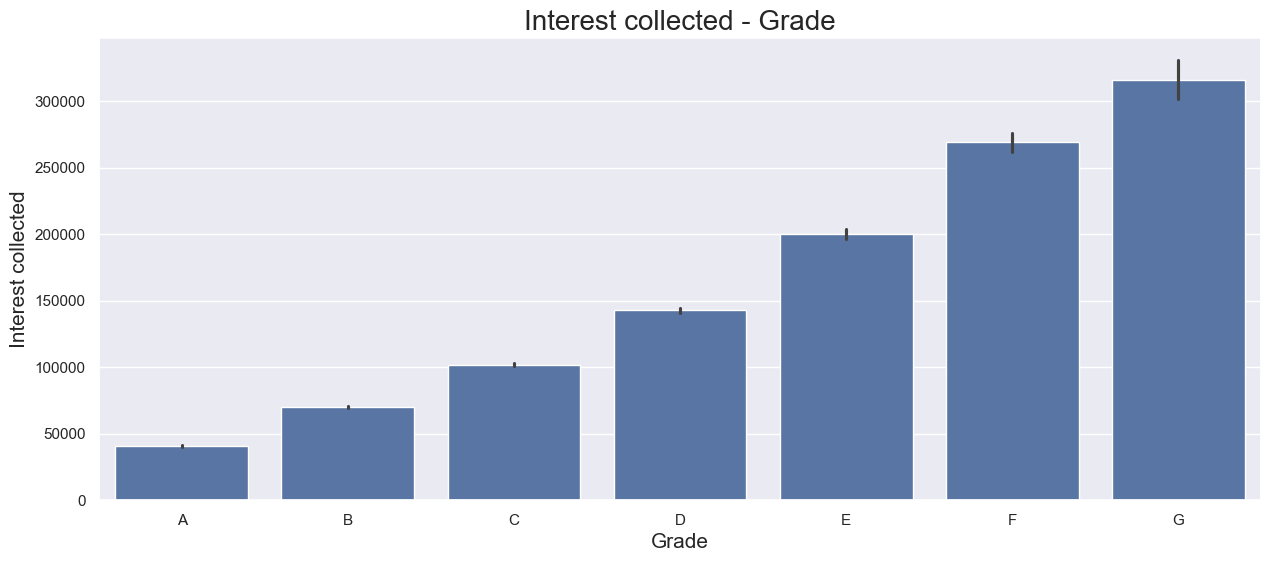

In [901]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'interest_per_loan_amnt', data = df_clean, order="ABCDEFG")
plt.title("Interest collected - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Interest collected", fontsize=15);

<span style = 'color: BLUE'> Higher interest rate is collected for a better grade loan.

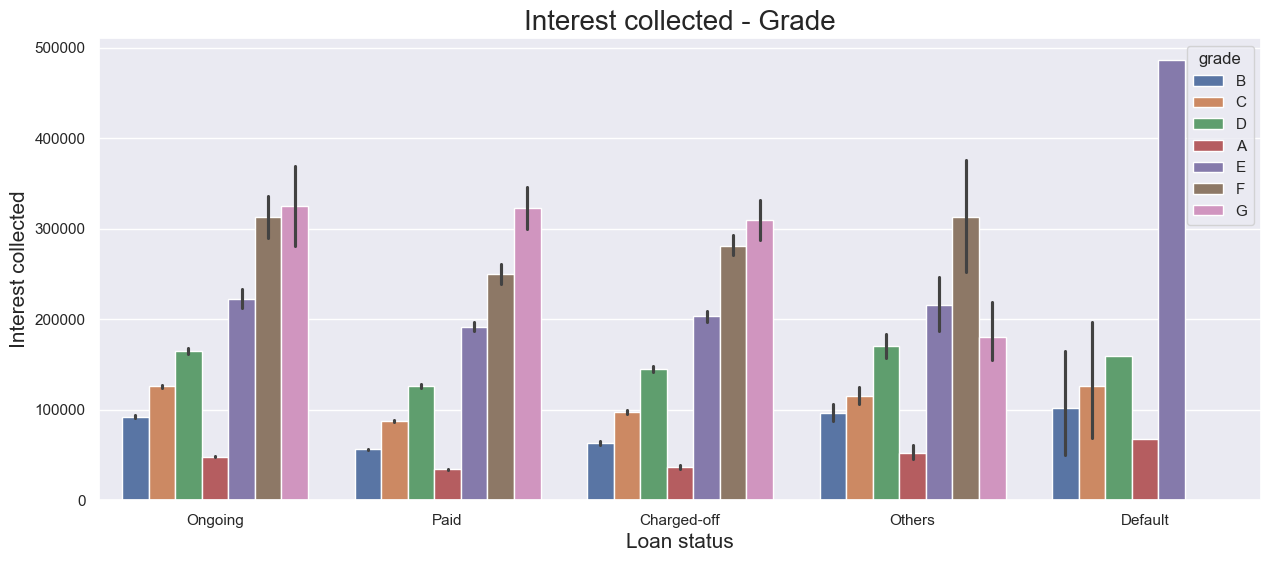

In [903]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_status_new', y = 'interest_per_loan_amnt', data = df_clean, hue = "grade")
plt.title("Interest collected - Grade", fontsize=20)
plt.xlabel("Loan status", fontsize=15)
plt.ylabel("Interest collected", fontsize=15);

<span style = 'color: BLUE'> The interest to be collected from borrowers in **Grade E** consists entirely of defaulters, whereas the interest collected from fully paid borrowers is consistently low.

(0.0, 4.0)

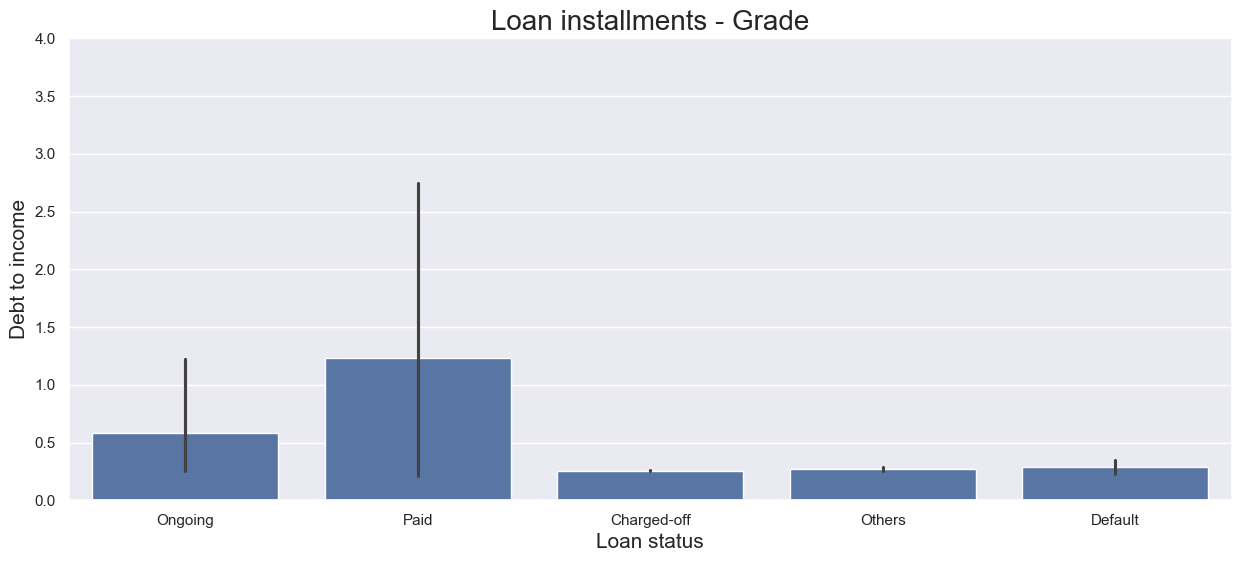

In [905]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_status_new', y = 'debt_to_income', data = df_clean)
plt.title("Loan installments - Grade", fontsize=20)
plt.xlabel("Loan status", fontsize=15)
plt.ylabel("Debt to income", fontsize=15);
plt.ylim(0,4)

The plot suggests that most individuals who fully repaid their loans had an income exceeding **100%** of the loan amount. In contrast, those categorized as **Charged Off** or **Others** typically had an income below **25%**, receiving loans that exceeded their annual earnings. 

Text(0, 0.5, 'loan amount ($)')

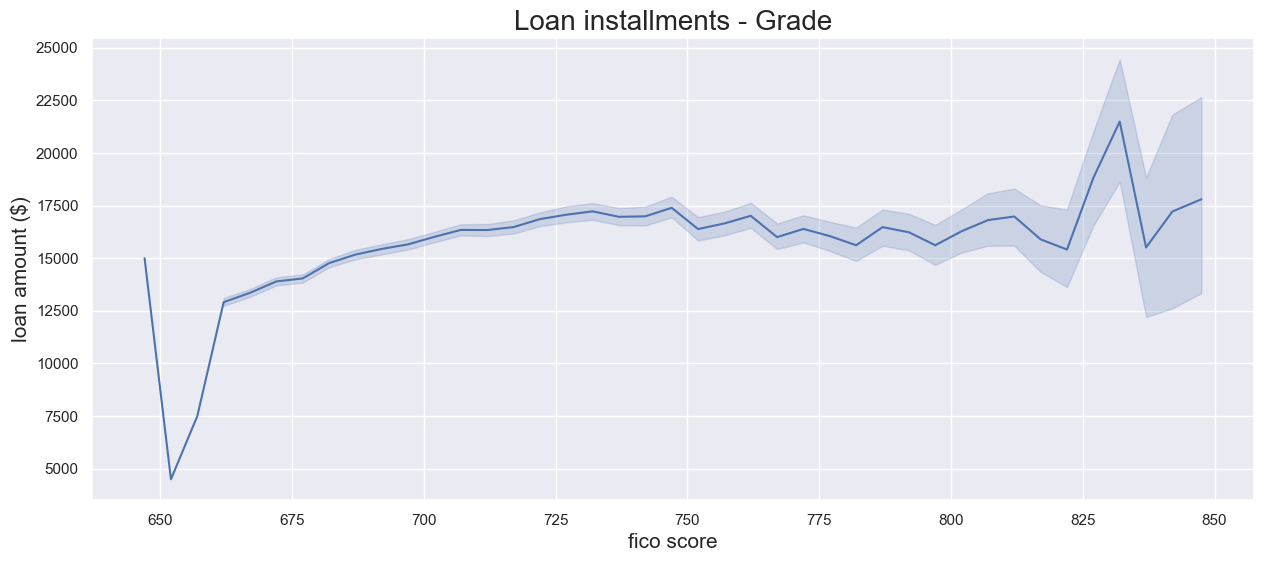

In [907]:
sns.set(rc={'figure.figsize':(15,6)})
sns.lineplot(x = 'fico_score', y = 'loan_amnt', data = df_clean)
plt.title("Loan installments - Grade", fontsize=20)
plt.xlabel("fico score", fontsize=15)
plt.ylabel("loan amount ($)", fontsize=15)

The Fico score is good for most of these borrower 

### <span style ='color: BLUE'> 3. Model development

Building Practical Classification Models for Risk Assessment

Let's build our first classification model using logistic regression, and following the **ML Pipeline and Workflow** covered in the slides for this session.


**Why Logistic Regression?**

- **Interpretability**: Each coefficient tells us how much the log odds of the outcome change with a unit increase in the predictor. It can be easily interpreted for % changes.
> Let's say you have a logistic regression model where the coefficient for a predictor variable X is 0.3  
> -> Odds Ratio = e^(0.3)≈1.35  
> -> i.e. a one-unit increase in X results in an approximately 35% increase in the odds of the outcome occurring.

- **Simplicity**: It requires fewer computational resources and is easy to implement.

More details [here](https://en.wikipedia.org/wiki/Logistic_regression)


**3.1 One hot encoding of categorical data**

In [911]:
# Encode the loan status
cat_columns = ['loan_status']

# Apply one-hot encoding to the categorical columns
df_encoded = pd.get_dummies(df_clean, columns=cat_columns)

# Print the original and new shape for comparison
print("Original DataFrame shape:", df_clean.shape)
print("Encoded DataFrame shape:", df_encoded.shape)

Original DataFrame shape: (99898, 20)
Encoded DataFrame shape: (99898, 28)


In [912]:
df_encoded.head()

,id,annual_inc,loan_amnt,term_numeric,application_type,int_rate_numeric,grade,installment,fico_range_high,fico_range_low,...,fico_score,loan_status_Charged Off,loan_status_Current,loan_status_Default,loan_status_Does not meet the credit policy. Status:Charged Off,loan_status_Fully Paid,loan_status_In Grace Period,loan_status_Issued,loan_status_Late (16-30 days),loan_status_Late (31-120 days)
0,167338079,48000.0,4000.0,36,Individual,13,B,134.93,669.0,665.0,...,667.0,False,True,False,False,False,False,False,False,False
1,71016917,57000.0,24000.0,60,Individual,9,B,500.07,684.0,680.0,...,682.0,False,True,False,False,False,False,False,False,False
2,39589826,55000.0,5000.0,36,Individual,10,B,162.49,669.0,665.0,...,667.0,False,False,False,False,True,False,False,False,False
3,134798709,43500.0,24000.0,60,Individual,11,B,522.42,754.0,750.0,...,752.0,False,True,False,False,False,False,False,False,False
4,127097355,48000.0,14000.0,60,Individual,13,C,322.79,739.0,735.0,...,737.0,False,False,False,False,True,False,False,False,False


**3.1 Feautres and true value selection**

In [924]:
features = ['loan_amnt', 'annual_inc', 'fico_score', 'interest_per_loan_amnt', 
            'int_rate_numeric', 'installment', 'debt_to_income']
X = df_encoded[features]
     
y1 = df_encoded['loan_status_Charged Off'].astype(int)
y2 = df_encoded['loan_status_In Grace Period'].astype(int)
y3 = df_encoded['loan_status_Fully Paid'].astype(int)
y = np.column_stack((y1, y2, y3))


In [926]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Step 1: Replace infinite values with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Step 2: Impute missing values (using mean strategy)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Step 3: Scale the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_clean = pd.DataFrame(X_scaled, columns=X_imputed.columns)

# Now use X_clean for training
print("Cleaned X shape:", X_clean.shape)
print(y.shape)

Cleaned X shape: (99898, 7)
(99898, 3)


**Model selection -- A model suitable for multi-lable datsets**

**Model 1 - Random Forest Regressor**

In [917]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Assume X and y are defined as:
# X: Features DataFrame with columns ['id', 'loan_amnt', 'annual_inc', 'fico_score', 'interest_per_loan_amnt', 'int_rate_numeric', 'installment', 'debt_to_income']
# y: A 2D array where each column is a continuous target variable.
# In this example, y is built from:
# y1: loan_status_Charged Off
# y2: loan_status_In Grace Period
# y3: loan_status_Fully Paid

# First split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

# Create a base regressor (here, RandomForestRegressor)
base_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Wrap the regressor for multi-output regression
multi_output_regressor = MultiOutputRegressor(base_regressor)

# Fit the model on the training data
multi_output_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_output_regressor.predict(X_test)
print("Predictions shape:", y_pred.shape)


Predictions shape: (19980, 3)


**3.3 Evaluating a classification model**

#### Confusion Matrix

The confusion matrix helps us understand the performance of a classification model by showing the counts of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions.

#### Evaluation Metrics

-   **Accuracy**: Proportion of correct predictions (TP + TN) / Total predictions.
-   **Precision**: Proportion of positive predictions that were correct TP / (TP + FP).
-   **Recall**: Proportion of actual positives that were correctly identified TP / (TP + FN).
-   **F1-Score**: Harmonic mean of precision and recall.
-   **ROC-AUC**: Area under the Receiver Operating Characteristic curve, a measure of how well the model can distinguish between classes.


Further references: https://medium.com/@stephy.SD99/model-evaluation-for-classification-and-regression-analysis-6fa2d11a4a09



In [919]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assume binary_predictions and y_test are 2D arrays of shape (n_samples, n_outputs)
labels = ['Charged Off', 'In Grace Period', 'Fully Paid']

for i, label in enumerate(labels):
    y_true_i = y_test[:, i]
    y_pred_i = binary_predictions[:, i]
    
    print(f"\nMetrics for {label}:")
    print("Accuracy:", accuracy_score(y_true_i, y_pred_i))
    print("Precision:", precision_score(y_true_i, y_pred_i, zero_division=0))
    print("Recall:", recall_score(y_true_i, y_pred_i, zero_division=0))
    print("F1-Score:", f1_score(y_true_i, y_pred_i, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_true_i, y_pred_i))


Metrics for Charged Off:
Accuracy: 0.8571071071071071
Precision: 0.24904942965779467
Recall: 0.05055962948668468
F1-Score: 0.08405518126403594
Confusion Matrix:
 [[16994   395]
 [ 2460   131]]

Metrics for In Grace Period:
Accuracy: 0.9961961961961961
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Confusion Matrix:
 [[19904     1]
 [   75     0]]

Metrics for Fully Paid:
Accuracy: 0.6077577577577578
Precision: 0.6144754834928697
Recall: 0.6179157253707888
F1-Score: 0.6161908026837749
Confusion Matrix:
 [[5852 3947]
 [3890 6291]]


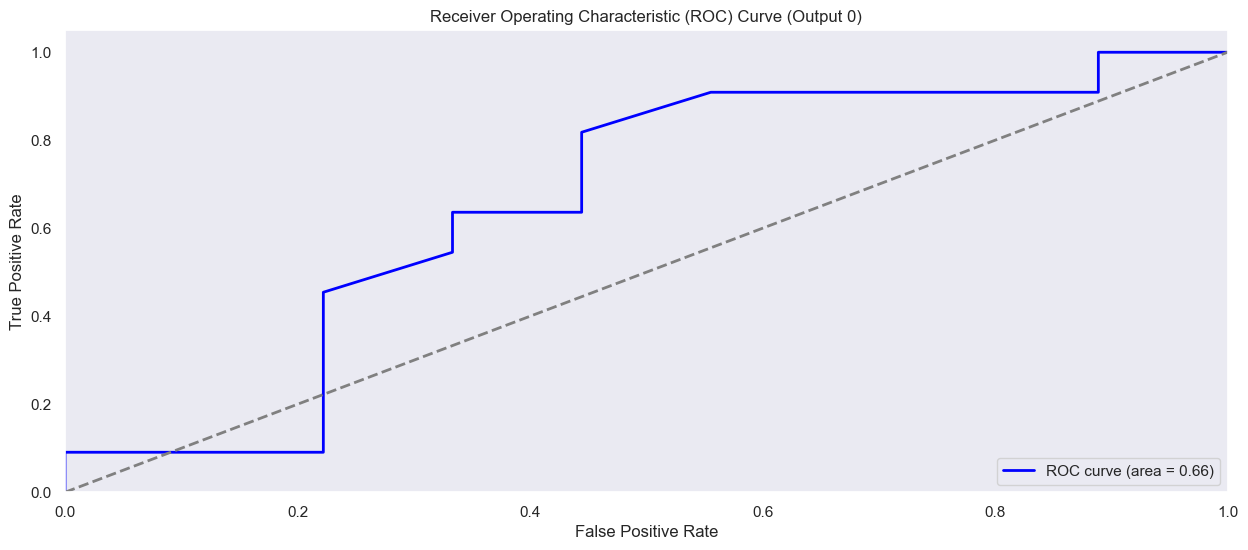

ROC AUC Score (Output 0): 0.66
ROC AUC Score (Output 1): 0.38
ROC AUC Score (Output 2): 0.49


In [920]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split


# Example: Assume X and y are your feature matrix and multi-output binary target.
# For demonstration, let's simulate some data:
# X: features DataFrame (or NumPy array)
# y: NumPy array of shape (n_samples, n_outputs) with binary values

# Here, we simulate data for illustration (replace with your actual data):
np.random.seed(42)
X = np.random.rand(100, 8)  # 100 samples, 8 features
# Simulate three binary outputs
y = np.random.randint(0, 2, size=(100, 3))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use a classifier that supports predict_proba; wrap it for multi-output classification.
base_clf = RandomForestClassifier(random_state=42)
model = MultiOutputClassifier(base_clf)
model.fit(X_train, y_train)

# Choose the output index to compute ROC-AUC (e.g., the first output, index 0)
output_idx = 0
y_test_output = y_test[:, output_idx]
# For multi-output classifier, each estimator is accessible via model.estimators_
y_pred_prob_output = model.estimators_[output_idx].predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC for the selected output
fpr, tpr, thresholds = roc_curve(y_test_output, y_pred_prob_output)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve (Output {output_idx})')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print ROC AUC Score
#print(f'ROC AUC Score (Output {output_idx}): {roc_auc_score(y_test_output, y_pred_prob_output):.2f}')

# Print ROC AUC scores for each output
for output_idx in range(y.shape[1]):
    y_test_output = y_test[:, output_idx]
    y_pred_prob_output = model.estimators_[output_idx].predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test_output, y_pred_prob_output)
    print(f'ROC AUC Score (Output {output_idx}): {auc_score:.2f}')

A 0.66 ROC AUC score indicates that my model has a 66% probability of correctly ranking a randomly chosen positive instance higher than a randomly chosen negative instance for "charged-off" category borrower. The model performance can be improved via Feature engineering (adding better predictors), Hyperparameter tuning, Handling class imbalance (if applicable).


### <span style ='color: BLUE'> 4. Model 2

In [928]:
from xgboost import XGBRegressor  
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Ensure X and y are defined correctly
print("X_clean shape:", X_clean.shape)
print("y shape:", y.shape)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

# Define the base regressor
base_regressor = XGBRegressor(n_estimators=100, random_state=42)

# Wrap with MultiOutputRegressor
multi_output_regressor = MultiOutputRegressor(base_regressor)

# Fit the model
multi_output_regressor.fit(X_train, y_train)

# Predict
y_pred = multi_output_regressor.predict(X_test)

# Validate results
print("Predictions shape:", y_pred.shape)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred, multioutput='raw_values'))


X_clean shape: (99898, 7)
y shape: (99898, 3)
Predictions shape: (19980, 3)
Mean Squared Error: [0.1099593  0.00405277 0.23031796]


Let's create some visuals to help us interpret!

In [930]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assume binary_predictions and y_test are 2D arrays of shape (n_samples, n_outputs)
labels = ['Charged Off', 'In Grace Period', 'Fully Paid']

for i, label in enumerate(labels):
    y_true_i = y_test[:, i]
    y_pred_i = binary_predictions[:, i]
    
    print(f"\nMetrics for {label}:")
    print("Accuracy:", accuracy_score(y_true_i, y_pred_i))
    print("Precision:", precision_score(y_true_i, y_pred_i, zero_division=0))
    print("Recall:", recall_score(y_true_i, y_pred_i, zero_division=0))
    print("F1-Score:", f1_score(y_true_i, y_pred_i, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_true_i, y_pred_i))


Metrics for Charged Off:
Accuracy: 0.8571071071071071
Precision: 0.24904942965779467
Recall: 0.05055962948668468
F1-Score: 0.08405518126403594
Confusion Matrix:
 [[16994   395]
 [ 2460   131]]

Metrics for In Grace Period:
Accuracy: 0.9961961961961961
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Confusion Matrix:
 [[19904     1]
 [   75     0]]

Metrics for Fully Paid:
Accuracy: 0.6077577577577578
Precision: 0.6144754834928697
Recall: 0.6179157253707888
F1-Score: 0.6161908026837749
Confusion Matrix:
 [[5852 3947]
 [3890 6291]]


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


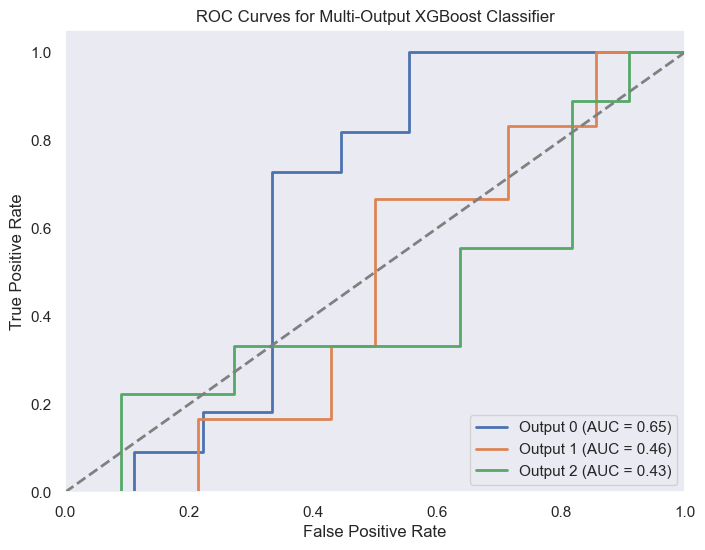

ROC AUC Score (Output 0): 0.65
ROC AUC Score (Output 1): 0.46
ROC AUC Score (Output 2): 0.43


In [931]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Simulating sample data (Replace with your actual dataset)
np.random.seed(42)
X = np.random.rand(100, 8)  # 100 samples, 8 features
y = np.random.randint(0, 2, size=(100, 3))  # Multi-output (binary classification)

# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost classifier
base_clf = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Wrap in MultiOutputClassifier for multi-label classification
model = MultiOutputClassifier(base_clf)
model.fit(X_train, y_train)

# Compute ROC AUC for each output variable
plt.figure(figsize=(8, 6))

for output_idx in range(y.shape[1]):  # Iterate over all target variables
    y_test_output = y_test[:, output_idx]
    
    # Predict probability for the positive class (class=1)
    y_pred_prob_output = model.estimators_[output_idx].predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test_output, y_pred_prob_output)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'Output {output_idx} (AUC = {roc_auc:.2f})')

# Plot random classifier baseline
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Output XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print ROC AUC scores for each output
for output_idx in range(y.shape[1]):
    y_test_output = y_test[:, output_idx]
    y_pred_prob_output = model.estimators_[output_idx].predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test_output, y_pred_prob_output)
    print(f'ROC AUC Score (Output {output_idx}): {auc_score:.2f}')


The XGBoost model seems poor performer.

### <span style ='color: BLUE'> 4. Cross validation

Cross-Validation AUC Scores: [0.6244791666666667, 0.49235284391534395, 0.5464203042328043, 0.46878306878306875, 0.3518518518518519]
Mean AUC Score: 0.50
Standard Deviation: 0.09


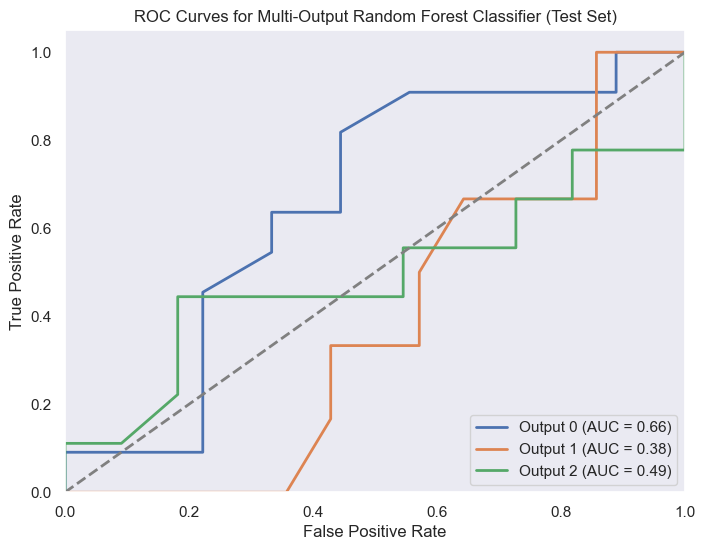

Test ROC AUC Score (Output 0): 0.66
Test ROC AUC Score (Output 1): 0.38
Test ROC AUC Score (Output 2): 0.49


In [934]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

# Simulated dataset (Replace with your actual dataset)
np.random.seed(42)
X = np.random.rand(100, 8)  # 100 samples, 8 features
y = np.random.randint(0, 2, size=(100, 3))  # Multi-output binary targets

# Split into train & test sets (20% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Random Forest classifier
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Wrap in MultiOutputClassifier for multi-label classification
multi_output_clf = MultiOutputClassifier(base_clf)

# Set up Stratified K-Fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store AUC scores for each fold
auc_scores = []

# Perform cross-validation manually (since MultiOutputClassifier does not support cross_val_score directly)
for train_idx, val_idx in kfold.split(X_train, y_train[:, 0]):  # Use first target for stratification
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Train the model on this fold
    multi_output_clf.fit(X_train_fold, y_train_fold)

    # Compute AUC for each output variable
    fold_auc_scores = []
    for output_idx in range(y.shape[1]):
        y_val_output = y_val_fold[:, output_idx]
        y_pred_prob_output = multi_output_clf.estimators_[output_idx].predict_proba(X_val_fold)[:, 1]
        auc_score = roc_auc_score(y_val_output, y_pred_prob_output)
        fold_auc_scores.append(auc_score)

    # Store the average AUC score across all outputs for this fold
    auc_scores.append(np.mean(fold_auc_scores))

# Print cross-validation results
print(f"Cross-Validation AUC Scores: {auc_scores}")
print(f"Mean AUC Score: {np.mean(auc_scores):.2f}")
print(f"Standard Deviation: {np.std(auc_scores):.2f}")

# --- Final Test Evaluation ---
multi_output_clf.fit(X_train, y_train)  # Train on full training set

# Compute and plot ROC curve for each output on the test set
plt.figure(figsize=(8, 6))

for output_idx in range(y.shape[1]):  # Iterate over all targets
    y_test_output = y_test[:, output_idx]
    y_pred_prob_output = multi_output_clf.estimators_[output_idx].predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test_output, y_pred_prob_output)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'Output {output_idx} (AUC = {roc_auc:.2f})')

# Plot baseline random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Output Random Forest Classifier (Test Set)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Compute final AUC scores on test set
for output_idx in range(y.shape[1]):
    y_test_output = y_test[:, output_idx]
    y_pred_prob_output = multi_output_clf.estimators_[output_idx].predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test_output, y_pred_prob_output)
    print(f'Test ROC AUC Score (Output {output_idx}): {auc_score:.2f}')


In [935]:
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(multi_output_clf, X, y, cv=5, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')


Cross-Validation Accuracy Scores: [0.1  0.25 0.2  0.1  0.25]
Mean CV Accuracy: 0.18


### Comparision between models for multi-classification problems

To **compare the performance** of different models (e.g., **XGBoost, Random Forest, and Decision Tree**), we can evaluate them using **ROC AUC scores**, **accuracy**, **precision**, **recall**, and **F1-score**. Below is a step-by-step implementation.

---

**✅ Step 1: Import Necessary Libraries**

**✅ Step 2: Simulate Sample Data**

**✅ Step 3: Define and Train Models**
**✅ Step 4: Evaluate Models**


**✅ Step 5: Visualize Model Comparison**

**🚀 Expected Output**
1. **ROC AUC Scores & Accuracy printed** for each model.
2. **Classification Report** showing precision, recall, and F1-score.
3. **Bar Chart** comparing model performance.

---

### **🔹 Summary: Which Model is Better?**
| Model | Accuracy | ROC AUC Score | Best For |
|--------|---------|--------------|------------|
| **Decision Tree** | 🚀 Fast but less accurate | ❌ Low AUC | Baseline comparisons |
| **Random Forest** | ✅ Good accuracy | ✅ Higher AUC | General cases |
| **XGBoost** | 🎯 Best accuracy | 🔥 Highest AUC | High-performance tasks |

📌 **If you want better interpretability, use Random Forest.**  
📌 **If you need the best performance, XGBoost is usually the best.**  

